#### Install and import neccesary packages to the the environment

In [ ]:
! pip install optuna textstat category_encoders pandas_profiling lightgbm plotly

In [1]:
%matplotlib inline

import os, random, optuna, textstat, multiprocessing, re
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas_profiling import ProfileReport

from scipy.stats import mode
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, balanced_accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.base import TransformerMixin, BaseEstimator

import category_encoders as ce

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, Dataset

import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

/tmp/ipykernel_23618/2474928789.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
/tmp/ipykernel_23618/2474928789.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


#### Import the Data

__note__: depending on the data source, this may require additional packages being installed and/or imported

In [ ]:
! mamba install -c conda-forge kaggle

In [ ]:
! kaggle competitions download -c playground-series-s3e8

In [ ]:
! unzip playground-series-s3e8.zip

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
df= pd.concat([train_df, test_df])

# 1. Exploratory Data Analysis
- look at the dataset basics (size of the data, data types, look at a few examples etc.). 
    - You should also note elements of the data collection, which might be important for developing models on the data. An example would be if all of the data samples come from a handful of sensors. In such a case you may want to consider using a `GroupKFold` split with the senors being the croups for cross-validation.
- look for any missing data
- look at the target value
- look for any outliers in the data

## 1(a) Profile the dataset

In [ ]:
display(df.head())

In [ ]:
print("df shape:", df.shape)

In [ ]:
print("train shape {}, test_shape: {}".format(train_df.shape, test_df.shape))

In [ ]:
df.info()

In [ ]:
ProfileReport(train_df)

From the initial dataset profiling:

- We have no missing data that we need to account for
- This is a regression problem with a skewed target variable
- There don't appear to be any interactions
- the target variable of price strongly correlates with the x,y,z and carat, which correlate with each other. These are size elements of the gemstones
- we have two categorical features of `color` and `clarity`

## 1(b) look at the missing values
- look for any patterns in missing data
- look at some examples of missing data

In [ ]:
df.isna().sum()

## 1(c) Look at the target variable

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(df['price'])

## 1(d) Look for Outliers

In [ ]:
df.describe()

In [ ]:
variable ='carat'

df[(df[variable] > df[variable].mean()+3*df[variable].std()) | (df[variable] < df[variable].mean()-3*df[variable].std())]

# 2. Import and Preprocess Data
- Import some helper functions to do imputation and deal with data outliers
- Use a function to do the data import and cleaning, so that it can be done as a repeatable process

In [3]:
def simple_impute(df):
    '''
    Impute missing values in a DataFrame. Impute the numerical columns by the median value for each column and
    impute the categorical columns by the most frequent, or mode, for each column
    Note: one can easily switch in different imputers for each of the data types to something like kNN or iterative

    Parameters:
    -----------
    df : pandas DataFrame
        Input DataFrame containing missing values.

    Returns:
    --------
    imp_df : pandas DataFrame
        DataFrame with imputed missing values.
    '''
    
    df= df.copy()
    # Impute missing values for numerical data
    # imp_num = IterativeImputer(estimator=ExtraTreesRegressor(), initial_strategy='median', max_iter=20)
    imp_num = SimpleImputer(strategy='median')
    numerical_df = df.select_dtypes("number")
    numerical_df = pd.DataFrame(data=imp_num.fit_transform(numerical_df), index=df.index, columns =numerical_df.columns)
    
    if df.select_dtypes("category").shape[1] >0:
        # Imput missing values for categorical data
        # imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(), initial_strategy='most_frequent', max_iter=20)
        imp_cat = SimpleImputer(strategy='most_frequent')
        categorical_df = df.select_dtypes("category")
        enc = OrdinalEncoder()
        categorical_df = pd.DataFrame(data=enc.fit_transform(categorical_df), columns=categorical_df.columns)
        categorical_imputations = enc.inverse_transform(imp_cat.fit_transform(categorical_df))
        categorical_df = pd.DataFrame(data=categorical_imputations, index=df.index, columns =categorical_df.columns, dtype="category")
        return categorical_df.join(numerical_df).reindex(columns= df.columns)
    else:
        return numerical_df

In [4]:
class ML_Impute(TransformerMixin):
    '''
    Impute missing values by treating the imputational as a machine learning problem. For numerical
    columns, we can treat the problem as a regression problem, and for categorical, a classification problem.
    For this method, we'll iterate through all of the columns with one column being the target variable
    and the others as being predictor variables
    '''

    def __init__(self, params={}):
        self.params = {}
        self.models = {}

    def fit(self, df):
        df = df.copy()
        # label encode categorical variables
        columns = df.columns.to_list()
        cat_cols = df.select_dtypes("category").columns.to_list()
        self.enc = OrdinalEncoder()
        df[cat_cols] = self.enc.fit_transform(df[cat_cols])

        # Randomized column selection
        for i in random.sample(range(len(df.columns)), len(df.columns)):

        # Starting with most null values to least
        # for i in np.argsort(-df.isnull().sum().values):
            column = columns[i]
            # Check to make sure there are null values that need to be imputed
            if not df[column].isnull().any():
                continue

            print("Creating Imputation Model for Column: {}".format(column))

            # Create train, test, and validation data using the null values of the column of interest
            X= df.loc[df[column].notnull()]
            y = X.pop(column)
            X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

            X_test = df.loc[df[column].isnull()]
            _ = X_test.pop(column)

            # If we have more data, we use more estimators for the imputation model
            n_estimators = min(100, int(len(X_train) / 10))
            if column in cat_cols:
                model = LGBMClassifier(**self.params, verbose=-1, n_estimators=n_estimators)
            else:
                model = LGBMRegressor(**self.params, verbose=-1, n_estimators=n_estimators)

            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                      callbacks = [early_stopping(min(20, int(len(X_train) / 10)))])
            print("Score of Column {} is {}".format(column, model.score(X,y)))
            self.models[column] = model 

    def transform(self, df):
        df = df.copy()

        # label encode categorical variables
        columns = df.columns.to_list()
        cat_cols = df.select_dtypes("category").columns.to_list()
        df[cat_cols] = self.enc.transform(df[cat_cols])

        for column in self.models.keys():
            X_test = df.loc[df[column].isnull()]
            _ = X_test.pop(column)
            model = self.models[column]
            preds =model.predict(X_test)
            m = df[column].isna()
            df.loc[m, column]  = preds.flatten()

        if len(cat_cols) >0:
            df[cat_cols] = self.enc.inverse_transform(df[cat_cols])
        return df

    def fit_transform(self, df):
        self.fit(df)
        df = self.transform(df)
        return df


In [5]:
def cap_outliers(df, variables=[None]):
    """
    Caps outlier values in a dataframe using the mean and standard deviation of each specified variable.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing the data to be capped.
    variables : list or None, optional (default=[None])
        The list of column names to cap outlier values. If None, all columns with numerical data will be capped.

    Returns:
    --------
    pandas DataFrame
        The dataframe with capped outlier values.

    Example:
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> data = {'A': [1, 2, 3, 1000], 'B': [4, 5, 6, 2000]}
    >>> df = pd.DataFrame(data)
    >>> df
          A     B
    0     1     4
    1     2     5
    2     3     6
    3  1000  2000
    >>> cap_outliers(df, variables=['A'])
         A     B
    0    1     4
    1    2     5
    2    3     6
    3  100    2000
    """
    df = df.copy()
    for variable in variables:
        upper_limit = df[variable].mean() + 3*df[variable].std()
        lower_limit = df[variable].mean() - 3*df[variable].std()
        df[variable] = np.where(df[variable]> upper_limit, upper_limit, np.where(
            df[variable]<lower_limit, lower_limit, df[variable]
        ))
    return df

In [6]:
# Wrapper function to read in, encode and impute missing values for the data

def preprocess_data(train_df, test_df=None, cat_features=[None], outlier_features=[None]):
    
    if test_df is not None:
        df = pd.concat([train_df, test_df])
    
    # Specify categorical variables
    for name in cat_features:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
            
    # Reform splits or create test data set, if applicable
    if test_df is not None:
        test = df.loc[test_df.index, :]
        train = df.drop(test_df.index)
    else:
        train, test = train_test_split(df, test_size=0.2)

    # Preprocessing for missing data and outliers
    imputer = ML_Impute()
    train = imputer.fit_transform(train)
    train = cap_outliers(train, outlier_features)

    test = imputer.transform(test)
    test = cap_outliers(test, outlier_features)


    return train, test

In [7]:
#Now, load in and preprocess the data

train_df = pd.read_csv("train.csv", index_col='id')
test_df = pd.read_csv("test.csv", index_col='id')

In [8]:
target_var = "price"

train, test = preprocess_data(train_df, test_df=test_df, cat_features = ['color', 'clarity', 'cut'], outlier_features=[])

/tmp/ipykernel_23618/2428355683.py:13: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[name].cat.add_categories("None", inplace=True)
/tmp/ipykernel_23618/2428355683.py:13: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[name].cat.add_categories("None", inplace=True)
/tmp/ipykernel_23618/2428355683.py:13: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[name].cat.add_categories("None", inplace=True)


# 3. Create a Baseline
- specify a baseline scoring function
    - __note__: the cross-validation for the scoring should be consistent with observations from the EDA
- create a baseline model. 
  - For regression use `LGBMRegressor` and `scoring='neg_root_mean_squared_error'` and multiply the result by `-1`
  - For classification use `LGBMClassifier` and `scoring='balanced_accuracy'`

In [9]:
def score_dataset(X, y, 
                  model=LGBMRegressor(n_estimators=1000, verbose=-1, random_state=42)
                 ):
    
    
    scores = cross_validate(
        model, X, y, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True
    )
    
    return {"Training":-1*np.mean(scores["train_score"]), "Validation":-1*np.mean(scores["test_score"])}

In [10]:
X = train.copy()
y = X.pop(target_var)
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

{'Training': 472.4058063880052, 'Validation': 591.1361484795598}

# 4. Featurize the Data

__Note:__ For featurizing data, really be creative. Most especially, use your subject matter expertise or domain knowledge to create features 

#### Tips on Creating Features
It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:

- Linear models learn sums and differences naturally, but can't learn anything more complex.
- Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
- Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
- Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
- Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

Example feature engineering steps:
- Remove uniformative features
- Create interactions
- Binning
- Indicate Outliers
- Try different encodings for categorical variables (https://contrib.scikit-learn.org/category_encoders/)

In [14]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [15]:
X = train.copy()
y = X.pop(target_var)
mi_scores = make_mi_scores(X, y)
mi_scores

carat      1.824272
x          1.673990
y          1.666055
z          1.616826
clarity    0.397042
color      0.284378
table      0.109602
cut        0.093469
depth      0.046285
Name: MI Scores, dtype: float64

In [16]:
# Try removing some of the uninformative features to see if that improves scores
uninformative_features = [
'cut', 'depth'
]

X = train.copy()
y = X.pop(target_var)
X = X.loc[:,~X.columns.isin(uninformative_features)]
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

{'Training': 486.53645075619045, 'Validation': 593.2199777968405}

For mathematical transforms, try things like log transforms:

`X['feature'] = np.log1p(X['feature'])`

For interations try multiplying or dividing features, especially between levels
of a categorical feature and a continuous feature. Use subject matter expertise here. Often, interactions between levels of a categorical variable and values of numerical variable make for good interactions

`X = X.join(ce.OneHotEncoder().fit_transform(df['A']) * df['B'], rsuffix='A_B_interation')`

In [11]:
def domain_transforms(df):
    X = pd.DataFrame(index=df.index)
    X['volume'] = df['x'] * df['y'] * df['z']
    
    X['clarity_letter'] = df['clarity'].str.replace('\d+', '')

    return X


In [18]:
X = train.copy()
y = X.pop(target_var)
X = X.join(domain_transforms(X))
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

/tmp/ipykernel_20384/214989015.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  X['clarity_letter'] = df['clarity'].str.replace('\d+', '')


{'Training': 468.5254224209627, 'Validation': 591.0989632202142}

Notes:

In [16]:
def cluster_labels(df, features, n_clusters=10):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = ce.OneHotEncoder().fit_transform(X_scaled)
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / (X_scaled.std(axis=0)+0.000001)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    X_new = pd.DataFrame(index=X.index)
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    X_new["Cluster"] = X_new["Cluster"].astype("category")
    return X_new["Cluster"]


def cluster_distance(df, features, n_clusters=10):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = ce.OneHotEncoder().fit_transform(X_scaled)
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / (X_scaled.std(axis=0)+0.000001)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])], index=X.index
    )
    return X_cd

Try adjusting what features you cluster together, `cluster_features`, as well as the number of clusters `n_clusters`

In [17]:
cluster_features = [
    'cut', 'color', 'clarity', 'carat'
]

In [ ]:
X = train.copy()
y = X.pop(target_var)
X = X.join(cluster_distance(X, cluster_features , n_clusters=10))
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

In [ ]:
X = train.copy()
y = X.pop(target_var)
X = X.join(cluster_labels(X, vape, n_clusters=10))
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

Notes:

In [12]:
def flag_outliers(df):
    df = df.copy()
    df = ce.OneHotEncoder().fit_transform(df)
    clf = LocalOutlierFactor()
    df["Outlier"] = clf.fit_predict(df)
    return df["Outlier"]

In [ ]:
X = train.copy()
y = X.pop(target_var)
X = X.join(flag_outliers(X))
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

Notes:

Try out different catgeorical encodings

In [12]:
X = train.copy()
y = X.pop(target_var)
X = ce.m_estimate.MEstimateEncoder(cols=['cut', 'color', 'clarity']).fit_transform(X, y)

score_dataset(X, y)

{'Training': 469.24840142962137, 'Validation': 590.8975871214503}

# 5. Finalize Features for Final Model

In [41]:
def create_features(df, target_var, test_df=None):
    X = df.copy()
    y = X.pop(target_var)
    
    if test_df is not None:
        X_test = test_df.copy()
        if target_var in X_test.columns:
            y_test = X_test.pop(target_var)
        else:
            y_test = None
        X = pd.concat([X, X_test])
        
    # Add in engineered features
    X = X.join(domain_transforms(X))

    
    # Reform splits
    if test_df is not None:
        X_test = X.loc[test_df.index, :]
        X.drop(test_df.index, inplace=True)
    
    if test_df is not None:
        return X, y, X_test, y_test
    else:
        return X, y

In [46]:
X, y, X_test, y_test = create_features(train, target_var, test)

# Do final encoding of categorical features
cat_encoder = ce.m_estimate.MEstimateEncoder(cols=['cut', 'color', 'clarity', 'clarity_letter'])
X = cat_encoder.fit_transform(X, y)
X_test = cat_encoder.transform(X_test)


/tmp/ipykernel_23618/214989015.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  X['clarity_letter'] = df['clarity'].str.replace('\d+', '')


In [52]:
score_dataset(X, y)

{'Training': 468.0096595648803, 'Validation': 590.7594921327014}

# 6. Hyperparameter Tuning
Use Optuna to find the beset set of hyperparameters for the final model
- you need to specify the objective (i.e. `'regression'`, `'multiclass'` with '`num_class`', etc.) 
- make sure the `folds` matches the fold evaluation scheme 
- you can set `early_stopping_rounds` and `num_boost_round` to custom values

In [64]:
def objective(trial, X, y):
    # Specify a search space using distributions across plausible values of hyperparameters.
    param = {
        "objective": "regression",
        "verbosity": -1,              
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }
    
    # Run LightGBM for the hyperparameter values
    lgbcv = lgb.cv(param,
                   lgb.Dataset(X, label=y),
                   folds= KFold(n_splits=5, shuffle=True),
                   callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)],                 
                   num_boost_round=1500
                  )
    
    cv_score = lgbcv['l2-mean'][-1]
    
    # Return metric of interest
    return cv_score

In [65]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study = optuna.create_study(direction='minimize')

# timeout is the time in seconds until the program stops the optimization, even if its not done
study.optimize(lambda trial: objective(trial, X, y), timeout=300, n_trials=20) 

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[318]	cv_agg's l2: 357963 + 9604.32
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[116]	cv_agg's l2: 343094 + 3929.59
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[84]	cv_agg's l2: 338438 + 12526.4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	cv_agg's l2: 355171 + 22697.5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[171]	cv_agg's l2: 471443 + 10420.7
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[91]	cv_agg's l2: 352682 + 11523.9
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	cv_agg's l2: 339047 + 9510.71
Training until validation scores don't improve for 20 rounds
Early stopping, bes

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [66]:
print(study.best_params)

{'lambda_l1': 4.306097847963761, 'lambda_l2': 6.10355348284128, 'num_leaves': 103, 'feature_fraction': 0.884160967544783, 'bagging_fraction': 0.9866976418443728, 'bagging_freq': 9, 'min_child_samples': 14}


In [67]:
print(study.best_value**0.5)

578.3790544244866


# 7. Fit final model and check predictions
- Fit an ensemble of models, using different data splits to create the ensemble members, and simple averaging or stacking for the final model
- you need to specify the objective (i.e. `'regression'`, `'multiclass'` with '`num_class`', etc.) 
- Lastly, plot the results and look at text accuracy to get a sense of how good the model is

In [75]:
class PredStacking(BaseEstimator):
    """
    A stacking ensemble method for machine learning. This class takes in a list of predictions done by
    base machine learning models and trains a final estimator on top of them to make the final predictions.
    """
    
    def __init__(self, final_estimator=LinearRegression()):
        self.final_estimator = final_estimator

    def fit(self, train_preds, y):
        """
        Fit the final estimator on the stacked data.

        Parameters:
        -----------
        train_preds: list
            A list of predictions done by base machine learning models on the training data.

        y: array-like, shape (n_samples,)
            The target values.

        Returns:
        --------
        self: object
            Returns self.
        """
        self.final_estimator.fit(np.array(train_preds).transpose(), y)
        return self

    def predict(self, test_preds):
        """
        Make predictions using the final estimator on the stacked data.

        Parameters:
        -----------
        test_preds: list
            A list of predictions done by base machine learning models on the test data.

        Returns:
        --------
        final_preds: array, shape (n_samples,)
            The predicted target values.
        """
        final_preds = self.final_estimator.predict(np.array(test_preds).transpose())
        return final_preds

    def fit_predict(self, preds, y):
        """
        Fit the final estimator on the stacked data and make predictions using the final estimator
        on the test data.

        Parameters:
        -----------
        train_preds: list
            A list of predictions done by base machine learning models on the training data.

        test_preds: list
            A list of predictions done by base machine learning models on the test data.

        y: array-like, shape (n_samples,)
            The target values.

        Returns:
        --------
        final_preds: array, shape (n_samples,)
            The predicted target values.
        """
        self.fit(preds, y)
        final_preds = self.predict(preds)
        return final_preds


Below, we are using different folds of the data as the method to generate ensemble members. Some hyperparameters that could be adjust is the number of folds (i.e. `n_splits` and `n_repeats`), the number of trees (i.e. `n_estimators`), wether to have early stopping to prevent overfitting and how many non-productive trees to allow before stopping (i.e. `early_stopping()`).

__note:__ make sure the error square matches the task. E.g., `mean_squared_error` for regression and `balanced_accuracy_score` for classifcation

In [73]:
test_preds = []
train_preds = []
skf = RepeatedKFold(n_splits=3, n_repeats=2)

for fold_idx, (train_index, valid_index) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    lgb_params = {
        'objective': '',
        'verbose': -1,
        'n_estimators': 1500,
        **study.best_params
    }
    model = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(20)])

    y_pred = model.predict(X_valid)
    score = mean_squared_error(y_valid, y_pred, squared=False)
    print("Fold {} Score: {}".format(fold_idx, score))
    print("----------------------")
    test_preds.append( model.predict(X_test))
    train_preds.append( model.predict(X))

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's l2: 336232
Fold 0 Score: 579.8551787361222
----------------------
Training until validation scores don't improve for 20 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[67]	valid_0's l2: 334737
Fold 1 Score: 578.5645343540294
----------------------


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 337323
Fold 2 Score: 580.7954595176038
----------------------
Training until validation scores don't improve for 20 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[69]	valid_0's l2: 339658
Fold 3 Score: 582.8021633200689
----------------------
Training until validation scores don't improve for 20 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[75]	valid_0's l2: 343874
Fold 4 Score: 586.407373169587
----------------------


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 324678
Fold 5 Score: 569.8055480168691
----------------------


In [76]:
# Use average for ensembling of the labels
# final_test_preds = np.mean(test_preds, axis=0)

# Use stacking for the Labels
ensembler = PredStacking(final_estimator=LinearRegression())
final_train_preds = ensembler.fit_predict(train_preds, y)
final_test_preds = ensembler.predict(test_preds)

Text(0.5, 1.0, 'Distribution of Predicted Target Variable on Test')

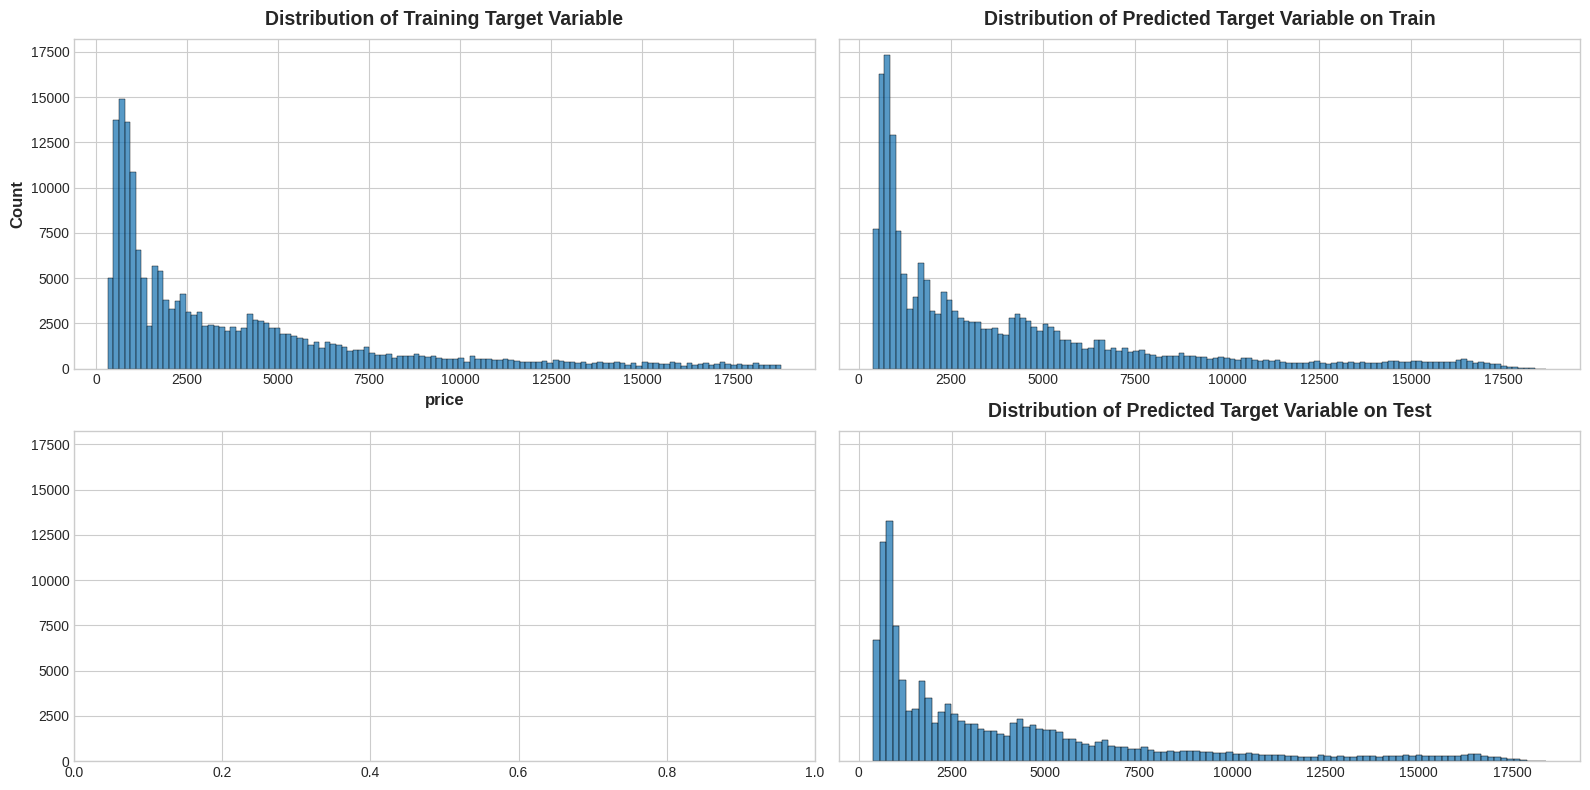

In [78]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(16,8))
sns.histplot(y, ax=axs[0,0])
axs[0,0].set_title("Distribution of Training Target Variable")
sns.histplot(final_train_preds , ax=axs[0,1])
axs[0,1].set_title("Distribution of Predicted Target Variable on Train")
sns.histplot(final_test_preds , ax=axs[1,1])
axs[1,1].set_title("Distribution of Predicted Target Variable on Test")

In [86]:
submission = pd.DataFrame(index=test.index)
submission['price'] = final_test_preds

In [88]:
submission.to_csv('submission_1MAR23_1.csv')